In [19]:
import os
import shutil
import zipfile
from torch.utils.data import Dataset, DataLoader, ConcatDataset,WeightedRandomSampler
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torchvision import models
import time
import tqdm
import os
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

from torchvision.models import mobilenet_v3_small, mobilenet_v3_large
from efficientnet_pytorch import EfficientNet
import timm  # PyTorch Image Models (timm) 라이브러리
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
# 1. 경로설정 및 압축해제
# 2. 이미지 형식 확인 및 데이터 분리
    # 이미지 형식변환
    # 레이블에 사용할 클래스명 가져오기
# 3. 커스텀 데이터 셋 
# 4. 이미지 전처리
# 5. 데이터셋 및 데이터로더 
# 6. 모델 정의
    # 분류기 수정
# 7. 손실함수 및 옵티마이저 등 여러 하이퍼파라미터 설정 
    # 얼리스타핑
# 8. 학습/평가함수
# 9. 웹캠

In [2]:
# 데이터 경로 설정
base_dir = os.getcwd()  # 현재 작업 디렉토리
# data_dir = os.path.join(base_dir, 'food_image')  # 이미지압축을 풀어놓을 폴더 생성

# 원래는 data_dir에 압축을 해제할 폴더명을 넣어주는데 
# food 데이터처럼 최상위폴더가 존재하는 경우에는 해당 이름으로 폴더 경로를 지정해줘야 중복을 피할 수 있었음
data_dir = os.path.join(base_dir, 'Food Classification dataset')
food_zip = os.path.join(base_dir, 'food_image_classification.zip')  # food-image-classification.zip 파일 경로

In [3]:
def extract_zip_if_needed(zip_folder_path, extract_path):   # zip 폴더위치 / 압축 풀 폴더 위치
    # 압축 파일이 풀리지 않았으면 최상위 디렉토리를 제거하고 압축 해제(경로를 복잡하지 않게 하기위해)
    if os.path.exists(data_dir):
        print(f"{data_dir} 폴더가 이미 존재합니다.")
        return
    else:
        print(f"{data_dir}가 존재하지 않습니다. 압축을 해제하겠습니다.")
        os.makedirs(extract_path, exist_ok=True)  # 압축 해제 폴더 생성(else문 밖에 있어도 상관없음/일단 안으로 넣어둠)
        # exist_ok = True : 폴더가 이미 존재하더라도 오류를 내지 않게 함



    # 압축 파일 내부의 최상위 디렉토리만 제거하고 파일을 추출하는 방식
    # 모든 파일을 한 폴더에 압축을 해제한다면 코드는 매우 간단해지지만 
    # 추후 test/valid 분리 시 각 클래스별로 일정한 비율로 분리하는게 어려움
    
    # zipfile.ZipFile(zipfile 모듈 사용하여 압축 해제)
    with zipfile.ZipFile(zip_folder_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)  # ZIP 파일의 폴더 구조를 그대로 유지하면서 압축 해제
    print(f"{zip_folder_path}폴더가 {extract_path}에 압축해제되었습니다..")
    

# 압축 해제
if os.path.exists(food_zip):
    print(f"{food_zip}의 압축을 해제하겠습니다.")
    extract_zip_if_needed(food_zip, data_dir)
else:
    print(f"{food_zip}폴더가 존재하지 않습니다.")
    
    
    
    
# 압축해제 정리 
# 1. 만약 zip 폴더 안에 최상위 폴더가 존재한다면 압축을 해제할 폴더를 별도로 만들지 않고 그냥 해제한다 
# 2. 최상위폴더는 없고 바로 클래스별 폴더들이 있는 상태라면 압축을 해제할 폴더를 만들어주는 코드를 추가하자 
# 대부분의 데이터 폴더가 위 2가지 경우에 속하는 것으로 보임

c:\Users\SBA\repository\yolo\food_image_classification.zip의 압축을 해제하겠습니다.
c:\Users\SBA\repository\yolo\Food Classification dataset 폴더가 이미 존재합니다.


In [4]:
# 총 클래스(폴더) 수 확인해보는 함수
directory = 'Food Classification dataset'
file_count = len(os.listdir(directory))
print(f"'{directory}' 이하의 모든 폴더의 파일 개수: {file_count}")

'Food Classification dataset' 이하의 모든 폴더의 파일 개수: 34


In [5]:
# 총 파일갯수를 확인해보는 함수
def count_all_files_in_directory(directory):
    total_files = 0
    # os.walk를 사용해 하위 디렉토리까지 모두 탐색(os.walk가 root/dirs/files 세가지를 반환함)
    for root, dirs, files in os.walk(directory):
        total_files += len(files)  # 현재 디렉토리의 파일 개수를 더함
        print(total_files)
    return total_files

# 파일 개수 출력
total_file = count_all_files_in_directory(directory)
print(f"'{directory}' 이하의 모든 폴더의 파일 개수: {total_file}")

0
1000
2500
2831
3138
3482
3809
4809
5809
6185
7685
7980
8225
9725
10075
11575
13123
14123
14425
14713
14992
15326
15540
15813
16136
17136
17280
17549
17854
18129
18373
19873
20873
22373
23873
'Food Classification dataset' 이하의 모든 폴더의 파일 개수: 23873


In [6]:
# directory = 'Food Classification dataset'

def convert_png_to_jpg(directory):
    # 변환된 파일이 있는지 확인하기 위한 플래그
    # converted = False

    # 폴더 내의 파일을 순회하며 PNG 파일을 찾음
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".png"):  # PNG 파일만 처리
                png_path = os.path.join(root, file)
                # 그냥 .jpg로 변환했더니 같은 파일명을 가진 jpg 파일에 덮어씌워지는 현상 발생
                # 학습데이터의 손실을 막기위해 다른 파일명으로 저장
                jpg_path = os.path.join(root, os.path.splitext(file)[0] + '_1.jpg')
                
                # root와 파일명을 분리한 결과를 출력
                # print(f"root: {root}")
                # print(f"os.path.splitext(file)[0]: {os.path.splitext(file)[0]}")
                
                # 디버깅 결과 
                # root: Food Classification dataset\Donut
                # os.path.splitext(file)[0]: Donut (1)
                # dirs는 root의 하위폴더인데 현재는 없음
                
                # PNG를 열고 JPG로 변환
                with Image.open(png_path) as img:
                        rgb_img = img.convert('RGB')
                        rgb_img.save(jpg_path, 'JPEG')
                    # PILLOW 라이브러리 내부규칙으로 파일확장자가 .jpg 일지라도 포맷을 지정할때는
                    # JPEG로 명시해야 PILLOW가 이해할수있다고 함 
                
                # PNG 파일 삭제 (원한다면 주석 처리 가능)
                os.remove(png_path)
                print(f"{png_path} -> {jpg_path} 변환 완료")
                
                # 변환이 성공하면 플래그 설정
                # converted = True

        #     # 첫 번째 PNG 파일 변환이 완료되면 멈춤
        #     if converted:
        #         break
        # if converted:
        #     break

# PNG를 JPG로 변환
convert_png_to_jpg(directory)

#### 시드함수추가

In [7]:
# 시드 설정 함수 정의
# 시드함수 : 무작위성을 통제하여 실행결과가 매번 동일하도록 함
# 무작위성 : 가중치가 무작위로 초기화되거나 데이터가 매번 다른순서로 학습된다던가 
# 드롭아웃을 할때도 제거하는 노드를 무작위로 정한다던가.. 배치순서도 동일하게 해주고! 
# 어떤 모델을 돌려도 환경이 동일하도록 설정해줌 
# 가중치 초기화는 아래에서도 했지만 모든 부분에 시드설정을 해줌으로서 안정성을 확보! 


# 시드를 설정하지 않은 경우: 모델을 두 번 학습시키면 학습 결과가 서로 다를 수 있습니다.
# 시드를 설정한 경우: 모델을 두 번 학습시키면 항상 동일한 결과를 얻을 수 있습니다.

def set_seed(seed):
    random.seed(seed)   # 파이썬 환경
    np.random.seed(seed)    # 넘파이 연산
    torch.manual_seed(seed) # cpu 연산
    if torch.cuda.is_available():   # gpu 연산
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 여러 GPU 사용 시
    torch.backends.cudnn.deterministic = True   # 연산 결과의 일관성 보장 (하지만 속도가 느려질 수 있음)
    torch.backends.cudnn.benchmark = False  # 입력 크기가 고정되지 않은 경우 성능을 최적화하는 기능을 끔

# 시드 설정
set_seed(42)    #팀원들끼리 동일한 숫자 넣기!

일단은 train파일을 train/valid/test로 나눠서 학습/테스트까지 전부 해보고    
이후에 train파일은 train/valid로만 나누고 test데이터는 직접 구한 것들로 만든 뒤 테스트해보기

In [8]:
# 경로 설정
train_data_dir = 'Food Classification dataset'
output_dir = 'Food_image_split'

def split_data_files_per_class(train_data_dir, output_dir, train_ratio=0.8):

    # 학습 및 검증 폴더 생성
    train_output_dir = os.path.join(output_dir, 'train')
    valid_output_dir = os.path.join(output_dir, 'valid')
    test_output_dir = os.path.join(output_dir, 'test')
    os.makedirs(train_output_dir, exist_ok=True)
    os.makedirs(valid_output_dir, exist_ok=True)
    os.makedirs(test_output_dir, exist_ok=True)


    # 각 클래스별 폴더에 대해 처리(클래스별로 동일한 비율로 분리하고싶음)
    for class_folder in os.listdir(train_data_dir):
        class_folder_path = os.path.join(train_data_dir, class_folder)
        
        # 폴더가 아닌 경우 건너뛰기(isdir - 폴더면 true반환)
        if not os.path.isdir(class_folder_path):
            continue

        # 각 클래스 폴더에서 파일 수집
        # shuffle 함수로 섞기 위해 리스트에 담아준다.
        all_files = []
        for file in os.listdir(class_folder_path):
            if os.path.isfile(os.path.join(class_folder_path, file)):
                all_files.append(os.path.join(class_folder_path, file))
        
        # 파일을 무작위로 섞음
        random.shuffle(all_files)
        
        total_num = len(all_files)
        # 파일 개수에 따른 비율 계산
        train_num = int(total_num * train_ratio)  # 80% 훈련 데이터
        valid_num = (total_num - train_num) // 2 
        
        # 파일 분리
        train_files = all_files[:train_num]  # 80% 훈련 데이터
        valid_files = all_files[train_num:train_num + valid_num]  # 10% 검증 데이터
        test_files = all_files[train_num + valid_num:]  # 10% 테스트 데이터

        # 각 파일을 새로운 폴더로 복사 (폴더 구조 유지)
        for file in train_files:
            # train_final_path = train/apple_pie
            train_final_path = os.path.join(train_output_dir, class_folder)
            os.makedirs(train_final_path, exist_ok=True)
            shutil.copy(file, train_final_path) # train_files의 file을 train_final_path로 복사

        for file in valid_files:
            valid_final_path = os.path.join(valid_output_dir, class_folder)
            os.makedirs(valid_final_path, exist_ok=True)
            shutil.copy(file, valid_final_path)
            
        for file in test_files:
            test_final_path = os.path.join(test_output_dir, class_folder)
            os.makedirs(test_final_path, exist_ok=True)
            shutil.copy(file, test_final_path)   

        # 클래스별로 일정 비율대로 잘 나뉘어졌는지 확인해보기
        print(f"{class_folder} - Train files: {len(train_files)}개, Valid files: {len(valid_files)}개, Test files: {len(test_files)}개")


# 데이터 분할 및 저장(train데이터가 있는 경로, 분리한 것을 저장할 경로, 비율)
split_data_files_per_class(train_data_dir, output_dir, train_ratio=0.8)

apple_pie - Train files: 800개, Valid files: 100개, Test files: 100개
Baked Potato - Train files: 1200개, Valid files: 150개, Test files: 150개
burger - Train files: 264개, Valid files: 33개, Test files: 34개
butter_naan - Train files: 245개, Valid files: 31개, Test files: 31개
chai - Train files: 275개, Valid files: 34개, Test files: 35개
chapati - Train files: 261개, Valid files: 33개, Test files: 33개
cheesecake - Train files: 800개, Valid files: 100개, Test files: 100개
chicken_curry - Train files: 800개, Valid files: 100개, Test files: 100개
chole_bhature - Train files: 300개, Valid files: 38개, Test files: 38개
Crispy Chicken - Train files: 1200개, Valid files: 150개, Test files: 150개
dal_makhani - Train files: 236개, Valid files: 29개, Test files: 30개
dhokla - Train files: 196개, Valid files: 24개, Test files: 25개
Donut - Train files: 1200개, Valid files: 150개, Test files: 150개
fried_rice - Train files: 280개, Valid files: 35개, Test files: 35개
Fries - Train files: 1200개, Valid files: 150개, Test files: 150개
Hot Do

In [9]:
class customDataset(Dataset):
    
    def __init__(self, files, root_dir, mode, transform=None, class_to_idx = None):

        # files: 파일 리스트
        # root_dir: 파일들이 있는 폴더 경로
        # mode: 'train' 또는 'test' 모드
        # transform: 이미지 변환 파이프라인
        # class_to_idx: 클래스 이름을 레이블로 변환하는 딕셔너리

        self.files = files
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # visual_datasets.append(customDataset(train_files[classname], os.path.join(train_dir, classname), 'train', transform=visual_transform,class_to_idx=class_to_idx))
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path).convert('RGB')  #이미지 읽어오기

        # 폴더 이름(클래스 이름)을 추출하여 레이블 설정
        folder_name = os.path.basename(os.path.dirname(img_path))
        label = self.class_to_idx[folder_name]  # class_to_idx의 키값으로 정수를 반환 

        # class_to_idx = {
        #     'apple_pie': 0,
        #     'burger': 1,
        #     'pizza': 2
        # }

        if self.transform:  # none 값이 아닐때/ 즉 변환모드를 지정한 경우
            img = self.transform(img)

        # 'train' 모드일 때는 이미지와 레이블 반환
        if self.mode == 'train':
            return img, label

        else:
            return img, label, img_path

#### 이미지 전처리

In [10]:
# 5. 이미지 전처리 설정
org_size = (256, 256)
img_size = 224
visual_transform = transforms.Compose([
    transforms.Resize(org_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(img_size),
    # 평균이 0.5 표준편차 0.5 (0~1사이의 실수)
    transforms.ToTensor()
    ])
train_transform = transforms.Compose([
    transforms.Resize(org_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(img_size),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # 색상 변화
    transforms.Normalize((0.6275, 0.5114, 0.3881), (0.2699, 0.2761, 0.2965))
])

test_transform = transforms.Compose([
    transforms.Resize(org_size),
    transforms.ToTensor(),
    transforms.Normalize((0.6203, 0.5135, 0.4028), (0.2769, 0.2820, 0.3035))
])

#### 이미지폴더 사용전 클래스명과 레이블을 미리 구해본 함수

In [11]:
# directory = 'Food Classification dataset'

def get_class_names_from_folder(directory):
    # 지정된 폴더 내의 하위 폴더 이름들을 클래스 이름으로 반환하는 함수
    class_names = []
    for folder in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, folder)):
            class_names.append(folder)
    return class_names   #list of str: 하위 폴더들의 이름(클래스 이름).

def create_class_to_idx_and_reverse(root_folder):
    #지정된 폴더 내의 하위 폴더 이름을 인덱스로 매핑한 딕셔너리와, 인덱스를 다시 클래스 이름으로 매핑하는 딕셔너리를 동시에 생성
    class_names = get_class_names_from_folder(root_folder)
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
    idx_to_class = {idx: class_name for idx, class_name in enumerate(class_names)}
    
    return class_to_idx, idx_to_class

# food_image 폴더 내의 하위 폴더들로부터 클래스 이름 및 인덱스 매핑 생성
class_to_idx, idx_to_class = create_class_to_idx_and_reverse(directory)

print(class_to_idx)
print(idx_to_class)

{'apple_pie': 0, 'Baked Potato': 1, 'burger': 2, 'butter_naan': 3, 'chai': 4, 'chapati': 5, 'cheesecake': 6, 'chicken_curry': 7, 'chole_bhature': 8, 'Crispy Chicken': 9, 'dal_makhani': 10, 'dhokla': 11, 'Donut': 12, 'fried_rice': 13, 'Fries': 14, 'Hot Dog': 15, 'ice_cream': 16, 'idli': 17, 'jalebi': 18, 'kaathi_rolls': 19, 'kadai_paneer': 20, 'kulfi': 21, 'masala_dosa': 22, 'momos': 23, 'omelette': 24, 'paani_puri': 25, 'pakode': 26, 'pav_bhaji': 27, 'pizza': 28, 'samosa': 29, 'Sandwich': 30, 'sushi': 31, 'Taco': 32, 'Taquito': 33}
{0: 'apple_pie', 1: 'Baked Potato', 2: 'burger', 3: 'butter_naan', 4: 'chai', 5: 'chapati', 6: 'cheesecake', 7: 'chicken_curry', 8: 'chole_bhature', 9: 'Crispy Chicken', 10: 'dal_makhani', 11: 'dhokla', 12: 'Donut', 13: 'fried_rice', 14: 'Fries', 15: 'Hot Dog', 16: 'ice_cream', 17: 'idli', 18: 'jalebi', 19: 'kaathi_rolls', 20: 'kadai_paneer', 21: 'kulfi', 22: 'masala_dosa', 23: 'momos', 24: 'omelette', 25: 'paani_puri', 26: 'pakode', 27: 'pav_bhaji', 28: 'pi

#### ImageFolder를 사용한 데이터 분류(클래스까지 인식해서 레이블링해줌)

In [12]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import os

# Custom ImageFolder to return file name along with image and label
class ImageFolderWithFilenames(ImageFolder):
    def __getitem__(self, index):
        # Get the original tuple (image, label)
        original_tuple = super(ImageFolderWithFilenames, self).__getitem__(index)

        # Get the image file path
        path, _ = self.samples[index]
        # Return the image, label, and the file name (path)
        return original_tuple + (path,)

In [13]:
from torchvision.datasets import ImageFolder

data_dir = 'Food_image_split'

batch_size = 32

visual_data = ImageFolder(root=f"{data_dir}/train", transform=visual_transform)
train_data = ImageFolder(root=f"{data_dir}/train", transform=train_transform)
valid_data = ImageFolder(root=f"{data_dir}/valid", transform=test_transform)
test_data = ImageFolderWithFilenames(root=f"{data_dir}/test", transform=test_transform)

In [14]:
# 1. 각 클래스의 샘플 수 파악
targets = np.array(train_data.targets)  # ImageFolder에서 레이블 가져오기
class_sample_count = np.bincount(targets)  # 각 클래스의 샘플 수 계산

In [16]:
print(class_sample_count)

[1200 1200 1200 1200 1238 1200 1200 1200  800  264  245  275  261  800
  800  300  236  196  280  800  241  230  223  267  171  218  258  800
  115  215  244  220  195  800]


In [17]:
# 2. 가중치 계산: 클래스가 적을수록 큰 가중치 부여
weights = 1. / class_sample_count  # 샘플 수가 적은 클래스일수록 높은 가중치
samples_weights = weights[targets]  # 각 샘플에 해당하는 가중치 할당

In [18]:
print(samples_weights)

[0.00083333 0.00083333 0.00083333 ... 0.00125    0.00125    0.00125   ]


In [20]:
# 3. WeightedRandomSampler 생성
sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)

In [23]:
visual_loader = DataLoader(visual_data, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler = sampler)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# 샘플러 사용시 valid data는 셔플 하지 않고 
# test data에서는 shuffle과 sampler 둘중 하나만 사용한다.

# 클래스별 레이블 출력
class_to_idx = train_data.class_to_idx

# 레이블별 클래스 출력
# 빈 딕셔너리 생성
idx_to_class = {}

# for문을 사용하여 class_to_idx를 순회하며 반전 딕셔너리 생성
for class_name, idx in class_to_idx.items():
    idx_to_class[idx] = class_name

#### rgb 평균과 표준편차를 구하는 함수

In [48]:
mean = torch.zeros(3)
std = torch.zeros(3)

# 전체 픽셀 수를 고려하기 위해 픽셀 개수를 저장
total_pixels = 0

for img, _ in train_data:
    # 텐서를 넘파이 배열로 변환 (텐서가 GPU에 있다면 .cpu()를 먼저 호출)
    # (이미지 전처리에서 텐서로 변환완료)
    # 하지만 커스텀 데이터셋에서 이미지를 로드하는 과정에서 PIL 라이브러리를 사용했고 
    # 해당 라이브러리는 이미지 데이터를 CPU 메모리에서 처리한다. 
    img_np = img.numpy()  # 텐서를 넘파이 배열로 변환
    # print(f"넘파이 배열로 변환된 이미지: {img_np.shape}")

    # 이미지 크기(height * width)를 통해 전체 픽셀 개수 계산
    total_pixels += img_np.shape[1] * img_np.shape[2]  # height * width

    # 각 채널의 모든 픽셀 값에 대해 평균과 표준 편차를 계산
    for i in range(3):  # R, G, B 채널
        mean[i] += img_np[i, :, :].sum()  # 각 채널의 모든 픽셀값 합계
        std[i] += (img_np[i, :, :] ** 2).sum()  # 각 채널의 모든 픽셀값 제곱의 합계

# 전체 픽셀 수를 이용해 평균 및 표준 편차 계산
mean /= total_pixels  # 평균 계산
std = torch.sqrt(std / total_pixels - mean ** 2)  # 표준 편차 계산

print(f"train의 RGB 채널 평균: {mean}")
print(f"train의 RGB 채널 표준 편차: {std}")
mean = torch.zeros(3)
std = torch.zeros(3)

# 전체 픽셀 수를 고려하기 위해 픽셀 개수를 저장
total_pixels = 0

for img, _ , _ in test_data:
    # 텐서를 넘파이 배열로 변환 (텐서가 GPU에 있다면 .cpu()를 먼저 호출)
    img_np = img.numpy() 
    # print(f"넘파이 배열로 변환된 이미지: {img_np.shape}")

    # 이미지 크기(height * width)를 통해 전체 픽셀 개수 계산
    total_pixels += img_np.shape[1] * img_np.shape[2]  # height * width

    # 각 채널의 모든 픽셀 값에 대해 평균과 표준 편차를 계산
    for i in range(3):  # R, G, B 채널
        mean[i] += img_np[i, :, :].sum()  # 각 채널의 모든 픽셀값 합계
        std[i] += (img_np[i, :, :] ** 2).sum()  # 각 채널의 모든 픽셀값 제곱의 합계

# 전체 픽셀 수를 이용해 평균 및 표준 편차 계산
mean /= total_pixels  # 평균 계산
std = torch.sqrt(std / total_pixels - mean ** 2)  # 표준 편차 계산

print(f"test의 RGB 채널 평균: {mean}")
print(f"test의 RGB 채널 표준 편차: {std}")


# train의 RGB 채널 평균: tensor([0.6275, 0.5114, 0.3881])
# train의 RGB 채널 표준 편차: tensor([0.2699, 0.2761, 0.2965])
# test의 RGB 채널 평균: tensor([0.6203, 0.5135, 0.4028])
# test의 RGB 채널 표준 편차: tensor([0.2769, 0.2820, 0.3035])

KeyboardInterrupt: 

In [24]:
def count_rgba_images(directory):
    rgba_count = 0
    total_count = 0

    # 이미지 파일의 확장자 목록
    image_extensions = ('.png', '.jpg', '.jpeg')

    # directory 하위의 모든 파일을 순회
    for class_dir, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(image_extensions):
                total_count += 1
                img_path = os.path.join(class_dir, file)
                try:
                    with Image.open(img_path) as img:
                        if img.mode == 'RGBA':
                            rgba_count += 1
                            print(f"RGBA 모드 파일: {img_path}")
                except Exception as e:
                    print(f"이미지 열기 실패: {img_path}, 오류: {e}")

    print(f"총 이미지 파일 수: {total_count}")
    print(f"RGBA 모드 이미지 파일 수: {rgba_count}")

    return rgba_count

# 사용 예시
# directory = "Food Classification dataset" 
count_rgba_images(directory)


# RGBA 모드 파일: Food Classification dataset\pakode\022.jpg
# 총 이미지 파일 수: 23873
# RGBA 모드 이미지 파일 수: 1
# 한개가 계속 안바뀜.. 열받..

RGBA 모드 파일: Food Classification dataset\pakode\022.jpg
총 이미지 파일 수: 23873
RGBA 모드 이미지 파일 수: 1


1

#### 가져올 데이터 시각화

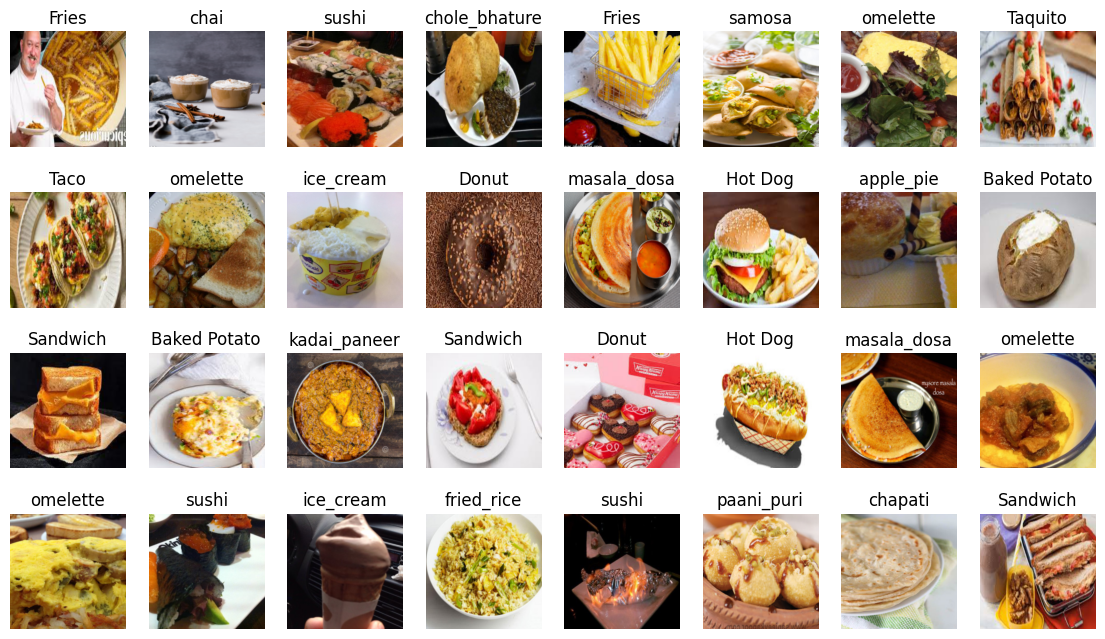

In [25]:
import matplotlib.pyplot as plt

# 배치사이즈만큼의 이미지를 시각화함함
images, labels = next(iter(visual_loader))
classes = idx_to_class # {0: 'apple_pie', 1: 'burger', 2: 'pizza', ...}


fig = plt.figure(figsize=(14, 8))
for i in range(batch_size):
    #4행 8열
    ax = fig.add_subplot(4, 8, i+1)   # 4행 8열 
    ax.set_title(classes[labels[i].item()]) # 레이블이 텐서형태라서 파이썬의 정수형으로 변환해서 사용해야함
    ax.axis('off')
    #컬러 채널 순서를 재정렬
    ax.imshow(images[i].permute(1, 2, 0))   # np.transpose로 변환해도됨
    # 안바꿔주면 에러도 없이 그냥 이미지만 안나옴 
    # img[i]가 c.h.w로 되어 있으니 h,w,c로 바꿔줘야 출력이 된다고 함함

plt.show()

#### 모델 정의 및 설정

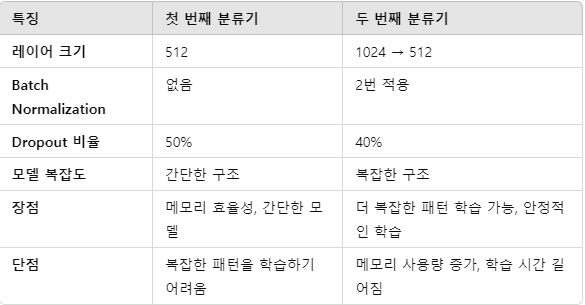

In [26]:
import torch
import torch.nn as nn
import torchvision
from efficientnet_pytorch import EfficientNet

# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# He 초기화를 적용하는 함수 정의
# He 초기화가 보통 relu 활성화 함수를 사용하는 신경망에 좋은 성능을 보임(적절한 값으로 초기화하여 가중치값을 좀 더 빨리 찾을수있다.)
# 초기화 함수는 linear와 conv2d 층에서만 적용한다.
def initialize_weights_he(module):
    if isinstance(module, nn.Linear) : # or isinstance(module, nn.Conv2d):
    # 사전 학습된 모델을 사용하고, 분류기만 변경했다면, 분류기(Linear) 부분만 초기화해도 충분
        torch.nn.init.kaiming_normal_(module.weight, nonlinearity='relu')   # module.weight : 가중치
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)


def modify_classifier(model, num_features, num_classes, model_name):
    """모델의 분류기 레이어를 수정하고 He 초기화를 적용하는 함수"""
    classifier = nn.Sequential(
        nn.Linear(num_features, 1024),  # 더 큰 크기의 레이어
        # 완전연결레이어 생성(fully connected layer(dense layer))
        # num_features : 입력크기, 1024 : 출력크기
        # 입력데이터를 1024의 노드로 변환
        nn.BatchNorm1d(1024),  # Batch Normalization 추가
        # 입력 데이터의 분포가 신경망 레이어를 지나면서 급격히 변하는 현상을 완화시키기 위해 도입된 방법
        # 왜 변하느냐 : 가중치가 업데이트 되니까 가중치가 곱해진 출력데이터가(다음레이어의 입력데이터) 변하게 되는것 --> 내부공변량변화
        # 이 변화는 신경망이 깊어질수록 더 두드러진다.
        # 그 값을 정규화해주면 급격히 변하지 않고 안정적으로 진행된다. 급격한 변화가 없기에 학습속도도 빨라진다.
        # BatchNorm1d란 : 1차원 데이터에 대해 배치정규화를 적용한다.
        # 1차원데이터 : 완전연결레이어 
        nn.ReLU(),
        # 비선형 활성화함수/음수값을 0으로 만들고 양수값은 그대로 통과시킴 - 비선형성을 도입하여 더 복잡한 패턴을 학습할수있게 함 
        # 왜 비선형함수가 필요한가 : 1. 선형함수만으로는 복잡한 패턴을 학습할 수 없다. 2. 기울기소실문제 해결 
        # 1. 선형레이어는 아무리 많이 쌓아도 하나의 큰 선형변환밖에 되지 않는다. 직선적인관계에 불과함 
        # 렐루가 가장 많이 사용되는 활성화함수(양수영역에서 기울기가 소실될 일이 없음)
        nn.Dropout(0.4),  # Dropout 비율 조정(모든 뉴런에 지나치게 의존하지 않도록 하여 과적합방지) - 테스트시에는 드랍아웃 비활성화 
        nn.Linear(1024, 512),   # 점진적으로 더 중요한 특징만 남겨서 마지막에는 분류에 적합한 고수준의 특징만 남기기 위함
        nn.BatchNorm1d(512),  # Batch Normalization 추가
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes),
    ).to(device)
    
    # 분류기의 모든 레이어를 순회하여 사용가능한 층에 He 초기화 적용
    classifier.apply(initialize_weights_he)
    
    # 분류기 레이어에 학습 가능하도록 requires_grad 설정
    for param in classifier.parameters():
        param.requires_grad = True


    # 모델마다 마지막 분류기 부분의 이름이 다름 
    # 모델의 분류기 부분을 각 모델 구조에 맞게 찾아서 교체하는 코드
    if model_name in ['efficientNetB2', 'efficientNetB0']:
        model._fc = classifier
    elif model_name in ['MNV3_large', 'MNV3_small']:
        model.classifier = classifier
    elif model_name in ['RESNET50', 'RESNET18']:
        model.fc = classifier

    return model

# 모델 생성 및 수정 함수
def create_model(model_name, num_classes):
    """모델 생성 및 수정"""
    if model_name == 'efficientNetB2':
        model = EfficientNet.from_pretrained('efficientnet-b2')
        num_features = model._fc.in_features
    elif model_name == 'efficientNetB0':
        model = EfficientNet.from_pretrained('efficientnet-b0')
        num_features = model._fc.in_features
    elif model_name == 'MNV3_large':
        model = torchvision.models.mobilenet_v3_large(pretrained=True)
        num_features = model.classifier[0].in_features
    elif model_name == 'MNV3_small':
        model = torchvision.models.mobilenet_v3_small(pretrained=True)
        num_features = model.classifier[0].in_features
    elif model_name == 'RESNET50':
        model = torchvision.models.resnet50(pretrained=True)
        num_features = model.fc.in_features
    elif model_name == 'RESNET18':
        model = torchvision.models.resnet18(pretrained=True)
        num_features = model.fc.in_features
    else:
        raise ValueError(f"Model '{model_name}' not recognized.")
    
    # 모든 파라미터 고정
    for param in model.parameters():
        param.requires_grad = False

    # 분류기 레이어 수정 및 학습 가능하게 설정
    model = modify_classifier(model, num_features, num_classes, model_name).to(device)

    # 모델을 GPU로 이동
    model = model.to(device)

    return model

# 선택 가능한 모델 출력
models = ['efficientNetB2', 'efficientNetB0', 'MNV3_large', 'MNV3_small', 'RESNET50', 'RESNET18']
print("사용 가능한 모델:")
for model_name in models:
    print(f"{model_name}")

# 다중 분류를 위한 클래스 수 설정
num_classes = 34

# 모델 선택
selected_model_name = "RESNET50"  # 선택하려는 모델 이름

# 모델 생성
model = create_model(selected_model_name, num_classes)  # selected_model_name을 사용
print(f"선택된 모델: {selected_model_name}")


사용 가능한 모델:
efficientNetB2
efficientNetB0
MNV3_large
MNV3_small
RESNET50
RESNET18


c:\Users\SBA\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SBA\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


선택된 모델: RESNET50


In [28]:
# EarlyStopping 클래스
# 모델 학습중에 과적합을 방지하기 위해 성능이 개선되지 않으면 학습을 중단하는 기능을 제공
# valid acc를 기준으로 계산됨
# 훈련손실은 계속 감소하는데 검증손실은 그대로거나 감소하지 않는다면 과적합 된것일 가능성이 높기때문
class EarlyStopping:
    # 클래스 초기화
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):

            # patience (int): 성능 개선이 없을 때 몇 번의 에포크까지 기다릴지.
            # verbose (bool): True일 경우 개선될 때마다 메시지 출력.
            # delta (float): 성능 개선으로 간주될 최소 변화량.
            # path: 모델을 저장할 경로
        self.patience = patience
        self.verbose = verbose
        self.counter = 0    # 검증손실이 개선되지 않은 에폭수 카운트
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')    #매우 큰값으로 초기화해서 첫 에포크 손실값으로 갱신됨
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss   # 검증손실은 작을 수록 좋은거니까 음수를 취해서 손실이 작은게 높은값이 되도록함
        # 처음에 호출됐을때는 best_score가 None이라서 초기값을 설정
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        # 지금까지의 best_scor
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''검증 손실이 감소하면 모델을 저장합니다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), self.path)  # 모델 상태 저장
        self.val_loss_min = val_loss

#### 손실함수 및 옵티마이저 정의(하이퍼파라미터 튜닝)

In [29]:
# 손실함수 및 옵티마이저 정의
lr = 0.0001
epochs = 20
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005)    # model_parameters : 모델의 모든 가중치와 편향 반환

# 학습률 조정(loss를 기준으로 한다면 mode가 min/ accuracy를 기준으로 한다면 max로 수정한다.)- 학습함수에서 loss값으로 부를 예정
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor = 0.5, patience = 3)
# 세번참고 0.5만큼 감소시킨다.

# base 디렉토리 설정
base_dir = os.getcwd()  # 현재 작업 디렉토리
# base 디렉토리 아래에 'model_food' 폴더 경로 설정
modelPath = os.path.join(base_dir, 'model_food')
# 'model_food' 폴더가 없으면 생성
os.makedirs(modelPath, exist_ok=True)
# EarlyStopping 인스턴스 생성 (patience=10) - 모델 저장 경로를 modelPath로 설정
path = os.path.join(modelPath, f"{selected_model_name}_best.pth")
early_stopping = EarlyStopping(patience=10, verbose=True, path=path)

#### fit 함수 정의

In [30]:
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


# 학습 함수  
# model, 손실함수, 모델 파라미터 업데이트를 위한 옵티마이저, 학습 에폭수, 학습/검증데이터를 배치단위로 제공하는 데이터로더
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):

    
    # param_group(리스트형태여서 인덱스로 접근): [{
    #     'params': [<Parameter tensor at 0x...>, ...],  # 모델 파라미터(가중치,편향) 리스트
    #     'lr': 0.001,  # 학습률
    #     'weight_decay': 0  # 가중치 감쇠
    # }]

    # 레이어마다 각각의 파라미터와 편향/ 학습률/하이퍼파라미터가 있고 
    # 초기화를 하는거니까 0번째를 가져와 0번째의 학습률을 pre_lr에 저장해두는것!
    


    # 그래프를 출력하기 위해 리스트에 누적하기 위해 초기화
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []


    for epoch in range(epochs):
        start = time.time()

        train_loss = 0
        train_acc = 0
        train_correct = 0
        # tqdm을 사용하여 각 에포크의 진행률 시각화
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=True)
        #(train_loader : 전체 학습데이터 나누기 배치사이즈(총 597개)/ desc : str / leave : 학습이 끝나도 진행률 바를 남길지(기본값은 true))

        # 1 epoch 중에 train에 해당하는 for 문
        for train_x, train_y in train_loader_tqdm:
            
            model.train()
            
            # 각 에포크마다 손실, 정확도 등을 추적할 변수를 초기화
   
            # train_x = img / train_y = label(정수형)
            # 학습데이터는 로딩될때 cpu메모리에 있기때문에 gpu로 옮겨줌(gpu에서 계산해야되니깐!!)
            train_x, train_y = train_x.to(device), train_y.to(device)
            
            # 기울기 초기화(한 에폭당 한번씩만 해주면된다 위치는 상관없음)
            optimizer.zero_grad()
            
            # 예측(입력데이터(이미지)를 모델에 넣어 계산)
            pred = model(train_x)   # 배치크기*클래스수(32 * 34)
            # print(f'pred : {pred}')
            
            # 손실계산 + softmax(CrossEntropyLoss 함수 내부적으로 소프트맥스가 결합되어 있음)
            loss = criterion(pred, train_y) 
            
            # 오차역전파
            loss.backward()
            
            # 진행(파라미터 업데이트)
            optimizer.step()
            
            train_loss += loss.item() #텐서값인 loss를 파이썬 기본자료형(float)으로 변환
            # print(f'train_loss : {train_loss}')
            # 파이썬 연산이 용이하도록 변경하기도 하고 텐서형태로 연산하거나 누적하면 메모리 누수가 발생할 수 있기에 변환해줌



            # 위에서 구해진 로짓값(pred)을 확률값으로 보고싶다면 소프트맥스 함수값을 직접 써줘야함 
            # probabilities = F.softmax(pred, dim=1)

            # # 각 클래스에 대한 확률 값을 출력
            # print(probabilities)
            
            
            # 소프트맥스
            # pred중 가장 큰값의 인덱스를 반환(로짓값이 제일 크면 확률값도 제일 크다)
            y_pred = pred.argmax(dim=1).cpu()
            # print(f'y_pred : {y_pred}')
            
            
            
            # y_pred와 train_y값이 같으면 train_correct 추가
            train_correct += y_pred.eq(train_y.cpu()).int().sum().item()   #boolean 값을 int로 변환한다는 명시적인 표현인데 빼도 작동함 
            # print(f'train_correct : {train_correct}')
            
            
            # 강사님 코드 
            # _, predicted = torch.max(pred.data, 1)    # 각 클래스의 확률중 가장 높은값과 그에 해당하는 인덱스를 반환
            # train_correct += (predicted == train_y).sum().item()


# pred 각 이미지(입력데이터)의 클래스별 로짓값
# y_pred 어떤 클래스에 대한 값이 가장큰지 보여줌(32개의 이미지에 대해 가장 값이 큰 인덱스를 반환)
#           pred : tensor([[-0.9683, -1.8666, -1.0749,  ..., -1.2777,  0.6948,  1.0047],
#           [-0.6027,  1.0496, -1.3117,  ...,  0.5032, -0.5502, -0.4839],
#           [ 0.2918, -0.0347, -0.9864,  ..., -1.0093, -0.1612, -0.8532],
#           ...,
#           [-0.8772, -1.7772, -1.9392,  ...,  0.4333,  0.7327, -0.1716],
#           [ 0.8438, -0.2054, -1.1120,  ...,  0.5759,  1.2411,  2.3969],
#           [-0.2601,  0.5588,  0.0164,  ..., -1.4648,  0.5939, -2.4142]],
#           grad_fn=<AddmmBackward0>)
#           y_pred : tensor([30, 11, 12,  7, 12, 12,  1, 24, 24, 16,  1,  4, 18, 14,  0, 14, 13,  3,
#           30, 17, 14,  0,  9, 30, 12,  3, 30, 33,  7, 19, 15,  3])


# 강사님 코드는 값을 cpu로 보내는 부분이 안보이는데.. 그래프를 그릴때에는 cpu 연산을 해야한다고 들었는데 질문해보기! 

# model.train()과 model.eval() 동작 차이점 
# 학습모드에서는 dropout이 활성화되고 batch normalization은 현재 배치의 평균과 분산을 사용
# 평가모드에서는 dropout은 비활성화되고 batch normalization은 훈련동안 추적된 평균과 분산값을 사용하여 데이터를 정규화한다. 



        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0

        # tqdm을 사용하여 각 에포크의 validation 진행률 시각화
        valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

        
        for valid_x, valid_y in valid_loader_tqdm:
            # 검증시에는 가중치를 업데이트 할 필요가 없으므로 메모리 사용량을 줄여 계산 속도를 높이기 위해 no_grad()를 사용한다.
            # 역전파를 비활성화
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device)
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()

            # 소프트맥스
            y_pred = pred.argmax(dim=1).cpu()
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum().item()
            


        # 한 에폭당 정확도와 손실값을 계산 
        # acc는 한 배치안의 모든 데이터의 수로 나누어 계산하고(모든 이미지에 대한 정확도) : 1배치당 32개의 이미지가 있음 총 19000여개
        # loss는 19000여장의 데이터를 32개로 나눈 597개의 배치중 1배치당 1개의 로스가 발생하며 
        # 위에서 loss값이 계산될때마다 train_loss값에 순차적으로 더해줬기 때문에 597로 나누어 1에폭당 최종 로스값을 계산해준다. 
        train_acc = train_correct / len(train_loader.dataset)   
        # train_correct는 1배치당 최대 32개가 나올 수 있고 / train_loader.dataset = 19000여개
        valid_acc = valid_correct / len(valid_loader.dataset)
        train_loss = train_loss / len(train_loader) # 597개
        valid_loss = valid_loss / len(valid_loader)
        print(f'train_correct : {train_correct}')
        print(f'valid_correct : {valid_correct}')
        print(f'train_acc :{train_acc}')
        print(f'valid_acc : {valid_acc}')

        # 정확도가 0~1사이의 값으로 출력되기 때문에 100 곱해줌
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss:.4f}, train acc: {train_acc * 100 :.3f}% / valid loss: {valid_loss:.4f}, valid acc: {valid_acc*100:.3f}%')

        # 계산된 정확도와 로스값을 리스트에 담아주기
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        
        # ReduceLROnPlateau 스케줄러를 사용하여 검증 손실에 따라 학습률을 조정
        scheduler.step(valid_loss)

        # 현재 학습률 출력(학습률 변화에 대한 출력을 하고자 2개의 변수를 사용했지만 생략가능)
        # ReduceLROnPlateau함수로 학습률이 조정되는데 변화하는 학습률 출력을 위해 값을 가져옴
        # param_group : 옵티마이저가 관리하는 파라미터들의 그룹(리스트) 
        # param_group(리스트형태여서 인덱스로 접근): [{
        #     'params': [<Parameter tensor at 0x...>, ...],  # 모델 파라미터(가중치,편향) 리스트
        #     'lr': 0.001,  # 학습률
        #     'weight_decay': 0  # 가중치 감쇠
        #       }]

        # 레이어마다 각각의 파라미터와 편향/ 학습률/하이퍼파라미터가 있고 
        # 초기화를 하는거니까 0번째를 가져와 0번째의 학습률을 now_lr 저장해두는것!
    
        now_lr = optimizer.param_groups[0]['lr']
        print(f'learning_rate {epoch+1}: {now_lr:.8f}')


        # EarlyStopping을 호출하여 학습 중단 할지말지 확인
        # 생성은 위에서 해줬고 이건 호출하는것!
        # def __call__(self, val_loss, model):
        early_stopping(valid_loss, model)

        # 학습 중단 조건을 충족하면 break
        # early_stopping 클래스 안에 early_stop 변수가 있고 초기값은 false인데
        # patience 횟수가 초과하면 true로 변경되도록 함 
        if early_stopping.early_stop:
            print("조기종료합니다.")
            break
        print('-' * 70)
        
    # 학습 및 검증 손실/정확도 시각화
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(valid_accuracies, label='Valid Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()


#### confusion matrix
#### 평가 및 시각화

In [33]:
from tqdm import tqdm

# 클래스 인덱스와 이름 매핑
# class_to_idx = class_to_idx
# idx_to_class = idx_to_class

# 혼동 행렬(Confusion Matrix) 그리는 함수
def plot_confusion_matrix(labels, predictions, class_names):
#(실제레이블, 예측레이블, 클래스명)
    # 혼동행렬 생성
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 7))
    # (혼동행렬데이터, annot:숫자값(맞춘개수), fmt=d 정수형식, 각 축의 클래스이름)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    
# 테스트 데이터에서 성능을 평가하고, 예측이 잘못된 이미지를 시각화하는 함수
def evaluate_and_visualize(model, test_loader, criterion):
    test_loss = 0
    test_correct = 0
    test_total = 0
    # acc는 밑에서 정답수와 토탈수로 계산한다.
    incorrect_labels = []
    incorrect_preds = []
    incorrect_filenames = []
    all_labels = []  # 전체 실제 라벨 저장
    all_preds = []   # 전체 예측 라벨 저장
    
    model.eval()
    with torch.no_grad():
        for test_x, test_y, filenames in tqdm(test_loader):
            test_x, test_y = test_x.to(device), test_y.to(device)
            pred = model(test_x)
            loss = criterion(pred, test_y)
            test_loss += loss.item()

            # 예측 결과 처리
            y_pred = pred.argmax(dim=1).cpu()  

            # 정확도 계산
            test_correct += y_pred.eq(test_y.cpu()).int().sum().item()
            test_total += test_y.size(0)    # 배치크기인 32개씩 누적
            
            # 전체 라벨과 예측값 저장 (혼동 행렬을 위한 데이터)
            # 넘파이 배열로 벡터연산하여 빠르게 계산가능 
            # 빠르다고 하지만 모델 학습시에는 파이토치 텐서를 사용해야 gpu가속화도 할 수있고 자동미분이 가능하므로 
            # 혼동행렬에만 넘파이 배열을 사용해준다고 한다.
            all_labels.extend(test_y.cpu().numpy())
            all_preds.extend(y_pred.cpu().numpy())
            # extend여러요소를 한번에 추가 
            # test_y나 y_pred가 한 배치마다 여러개 나오니까 extend해야함
            
            # 잘못된 예측 저장 (각 요소별로 비교)
            for i in range(len(y_pred)):    #32개
                if y_pred[i] != test_y[i]:  # 예측과 실제가 다른 경우에만 저장
                    incorrect_labels.append(test_y.cpu()[i].item()) #시각화할거라서 cpu로 / 텐서를 기본정수로 변환하기위해 item()
                    incorrect_preds.append(y_pred.cpu()[i].item())
                    incorrect_filenames.append(filenames[i])

    test_accuracy = test_correct / test_total
    print(f"test_correct: {test_correct}, test_total: {test_total}")
    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')
    
    # 혼동 행렬 시각화
    class_names = list(class_to_idx.keys())
    plot_confusion_matrix(all_labels, all_preds, class_names)
    
    # 잘못 예측된 파일 이름만 추출
    # filenames가 이미지 경로이므로 파일명만 추출해야함
    just_filenames = []
    for path in incorrect_filenames:
        just_filenames.append(os.path.basename(path))

    # 예측이 잘못된 이미지 시각화
    fig = plt.figure(figsize=(16, 16))
    for i in range(min(16, len(incorrect_filenames))):
        # min(16, len(incorrect_filenames))는 16장 또는 잘못 예측된 이미지의 수 중 작은 값을 사용
        # 즉, 잘못 예측된 이미지가 16장보다 적으면 그 수만큼만 시각화
        # 16만 쓰면 인덱스에러남
        ax = fig.add_subplot(4, 4, i + 1)
        # 잘못된 예측된 이미지 불러오기
        image = Image.open(incorrect_filenames[i])
        ax.imshow(image)

        # 실제 라벨과 예측 라벨 가져오기
        # 딕셔너리에서 밸류값을 기준으로 키값을 가져오는 메서드는 없기때문에
        # class_to_idx만 구해두었다면 여기에서 역으로 변환하는 식을 써야한다.(for문을 돌릴수도 있다.)
        # 뭐가 편한지는 선택! 
        true_label = idx_to_class[incorrect_labels[i]]
        pred_label = idx_to_class[incorrect_preds[i]]
        ax.set_title(f'Pred: {pred_label}, Label: {true_label}, \n{just_filenames[i]}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

#### 학습

Epoch 1/20 [Train]: 100%|██████████| 597/597 [06:16<00:00,  1.59it/s]


train_correct : 8676
valid_correct : 1705
train_acc :0.4544311753614079
valid_acc : 0.7151845637583892
407.972sec : [Epoch 1/20] -> train loss: 2.0572, train acc: 45.443% / valid loss: 1.1541, valid acc: 71.518%
learning_rate 1: 0.00010000
Validation loss decreased (inf --> 1.154109).  Saving model ...
----------------------------------------------------------------------


Epoch 2/20 [Train]: 100%|██████████| 597/597 [06:13<00:00,  1.60it/s]


train_correct : 13199
valid_correct : 1791
train_acc :0.6913366855227321
valid_acc : 0.7512583892617449
395.059sec : [Epoch 2/20] -> train loss: 1.0963, train acc: 69.134% / valid loss: 0.8868, valid acc: 75.126%
learning_rate 2: 0.00010000
Validation loss decreased (1.154109 --> 0.886842).  Saving model ...
----------------------------------------------------------------------


Epoch 3/20 [Train]: 100%|██████████| 597/597 [05:53<00:00,  1.69it/s]


train_correct : 14434
valid_correct : 1870
train_acc :0.7560234653257909
valid_acc : 0.7843959731543624
375.497sec : [Epoch 3/20] -> train loss: 0.8553, train acc: 75.602% / valid loss: 0.7680, valid acc: 78.440%
learning_rate 3: 0.00010000
Validation loss decreased (0.886842 --> 0.767993).  Saving model ...
----------------------------------------------------------------------


Epoch 4/20 [Train]: 100%|██████████| 597/597 [04:31<00:00,  2.20it/s]


train_correct : 15057
valid_correct : 1882
train_acc :0.7886549340037712
valid_acc : 0.7894295302013423
293.231sec : [Epoch 4/20] -> train loss: 0.7255, train acc: 78.865% / valid loss: 0.7237, valid acc: 78.943%
learning_rate 4: 0.00010000
Validation loss decreased (0.767993 --> 0.723700).  Saving model ...
----------------------------------------------------------------------


Epoch 5/20 [Train]: 100%|██████████| 597/597 [04:30<00:00,  2.21it/s]


train_correct : 15373
valid_correct : 1908
train_acc :0.8052063691598575
valid_acc : 0.8003355704697986
292.249sec : [Epoch 5/20] -> train loss: 0.6672, train acc: 80.521% / valid loss: 0.6714, valid acc: 80.034%
learning_rate 5: 0.00010000
Validation loss decreased (0.723700 --> 0.671359).  Saving model ...
----------------------------------------------------------------------


Epoch 6/20 [Train]: 100%|██████████| 597/597 [04:33<00:00,  2.19it/s]


train_correct : 15608
valid_correct : 1905
train_acc :0.8175151896082129
valid_acc : 0.7990771812080537
295.093sec : [Epoch 6/20] -> train loss: 0.6146, train acc: 81.752% / valid loss: 0.6688, valid acc: 79.908%
learning_rate 6: 0.00010000
Validation loss decreased (0.671359 --> 0.668786).  Saving model ...
----------------------------------------------------------------------


Epoch 7/20 [Train]: 100%|██████████| 597/597 [04:44<00:00,  2.10it/s]


train_correct : 15855
valid_correct : 1937
train_acc :0.8304525455688246
valid_acc : 0.8125
320.128sec : [Epoch 7/20] -> train loss: 0.5725, train acc: 83.045% / valid loss: 0.6322, valid acc: 81.250%
learning_rate 7: 0.00010000
Validation loss decreased (0.668786 --> 0.632237).  Saving model ...
----------------------------------------------------------------------


Epoch 8/20 [Train]: 100%|██████████| 597/597 [05:38<00:00,  1.76it/s]


train_correct : 16088
valid_correct : 1941
train_acc :0.8426566100984706
valid_acc : 0.8141778523489933
360.571sec : [Epoch 8/20] -> train loss: 0.5247, train acc: 84.266% / valid loss: 0.6281, valid acc: 81.418%
learning_rate 8: 0.00010000
Validation loss decreased (0.632237 --> 0.628124).  Saving model ...
----------------------------------------------------------------------


Epoch 9/20 [Train]: 100%|██████████| 597/597 [04:30<00:00,  2.21it/s]


train_correct : 16259
valid_correct : 1942
train_acc :0.8516132411481249
valid_acc : 0.8145973154362416
297.417sec : [Epoch 9/20] -> train loss: 0.4868, train acc: 85.161% / valid loss: 0.6107, valid acc: 81.460%
learning_rate 9: 0.00010000
Validation loss decreased (0.628124 --> 0.610697).  Saving model ...
----------------------------------------------------------------------


Epoch 10/20 [Train]: 100%|██████████| 597/597 [06:34<00:00,  1.51it/s]


train_correct : 16354
valid_correct : 1946
train_acc :0.8565891472868217
valid_acc : 0.8162751677852349
416.305sec : [Epoch 10/20] -> train loss: 0.4781, train acc: 85.659% / valid loss: 0.6025, valid acc: 81.628%
learning_rate 10: 0.00010000
Validation loss decreased (0.610697 --> 0.602527).  Saving model ...
----------------------------------------------------------------------


Epoch 11/20 [Train]: 100%|██████████| 597/597 [04:58<00:00,  2.00it/s]


train_correct : 16497
valid_correct : 1955
train_acc :0.8640791954745443
valid_acc : 0.8200503355704698
320.529sec : [Epoch 11/20] -> train loss: 0.4584, train acc: 86.408% / valid loss: 0.5862, valid acc: 82.005%
learning_rate 11: 0.00010000
Validation loss decreased (0.602527 --> 0.586212).  Saving model ...
----------------------------------------------------------------------


Epoch 12/20 [Train]: 100%|██████████| 597/597 [04:32<00:00,  2.19it/s]


train_correct : 16639
valid_correct : 1954
train_acc :0.8715168657029122
valid_acc : 0.8196308724832215
294.639sec : [Epoch 12/20] -> train loss: 0.4192, train acc: 87.152% / valid loss: 0.5728, valid acc: 81.963%
learning_rate 12: 0.00010000
Validation loss decreased (0.586212 --> 0.572850).  Saving model ...
----------------------------------------------------------------------


Epoch 13/20 [Train]: 100%|██████████| 597/597 [04:34<00:00,  2.17it/s]


train_correct : 16673
valid_correct : 1951
train_acc :0.8732977163209721
valid_acc : 0.8183724832214765
296.572sec : [Epoch 13/20] -> train loss: 0.4237, train acc: 87.330% / valid loss: 0.5751, valid acc: 81.837%
learning_rate 13: 0.00010000
EarlyStopping counter: 1 out of 10
----------------------------------------------------------------------


Epoch 14/20 [Train]: 100%|██████████| 597/597 [04:37<00:00,  2.15it/s]


train_correct : 16695
valid_correct : 1987
train_acc :0.8744500314267756
valid_acc : 0.8334731543624161
299.496sec : [Epoch 14/20] -> train loss: 0.4048, train acc: 87.445% / valid loss: 0.5468, valid acc: 83.347%
learning_rate 14: 0.00010000
Validation loss decreased (0.572850 --> 0.546778).  Saving model ...
----------------------------------------------------------------------


Epoch 15/20 [Train]: 100%|██████████| 597/597 [05:08<00:00,  1.93it/s]


train_correct : 16766
valid_correct : 1990
train_acc :0.8781688665409596
valid_acc : 0.834731543624161
330.632sec : [Epoch 15/20] -> train loss: 0.3960, train acc: 87.817% / valid loss: 0.5429, valid acc: 83.473%
learning_rate 15: 0.00010000
Validation loss decreased (0.546778 --> 0.542942).  Saving model ...
----------------------------------------------------------------------


Epoch 16/20 [Train]: 100%|██████████| 597/597 [04:35<00:00,  2.17it/s]


train_correct : 16863
valid_correct : 1988
train_acc :0.8832495285983658
valid_acc : 0.8338926174496645
297.204sec : [Epoch 16/20] -> train loss: 0.3799, train acc: 88.325% / valid loss: 0.5434, valid acc: 83.389%
learning_rate 16: 0.00010000
EarlyStopping counter: 1 out of 10
----------------------------------------------------------------------


Epoch 17/20 [Train]: 100%|██████████| 597/597 [04:41<00:00,  2.12it/s]


train_correct : 17048
valid_correct : 1993
train_acc :0.892939451078986
valid_acc : 0.8359899328859061
303.029sec : [Epoch 17/20] -> train loss: 0.3551, train acc: 89.294% / valid loss: 0.5424, valid acc: 83.599%
learning_rate 17: 0.00010000
Validation loss decreased (0.542942 --> 0.542376).  Saving model ...
----------------------------------------------------------------------


Epoch 18/20 [Train]: 100%|██████████| 597/597 [04:29<00:00,  2.22it/s]


train_correct : 17029
valid_correct : 1997
train_acc :0.8919442698512466
valid_acc : 0.8376677852348994
291.371sec : [Epoch 18/20] -> train loss: 0.3513, train acc: 89.194% / valid loss: 0.5364, valid acc: 83.767%
learning_rate 18: 0.00010000
Validation loss decreased (0.542376 --> 0.536410).  Saving model ...
----------------------------------------------------------------------


Epoch 19/20 [Train]: 100%|██████████| 597/597 [06:00<00:00,  1.66it/s]


train_correct : 17064
valid_correct : 1990
train_acc :0.8937774984286612
valid_acc : 0.834731543624161
396.443sec : [Epoch 19/20] -> train loss: 0.3387, train acc: 89.378% / valid loss: 0.5322, valid acc: 83.473%
learning_rate 19: 0.00010000
Validation loss decreased (0.536410 --> 0.532195).  Saving model ...
----------------------------------------------------------------------


Epoch 20/20 [Train]: 100%|██████████| 597/597 [05:37<00:00,  1.77it/s]


train_correct : 17099
valid_correct : 1980
train_acc :0.8956107270060758
valid_acc : 0.8305369127516778
359.170sec : [Epoch 20/20] -> train loss: 0.3333, train acc: 89.561% / valid loss: 0.5352, valid acc: 83.054%
learning_rate 20: 0.00010000
EarlyStopping counter: 1 out of 10
----------------------------------------------------------------------


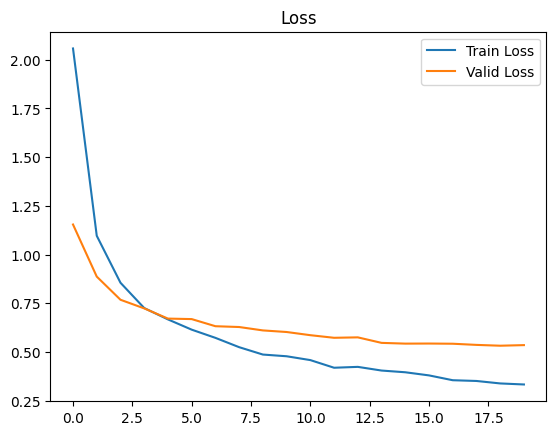

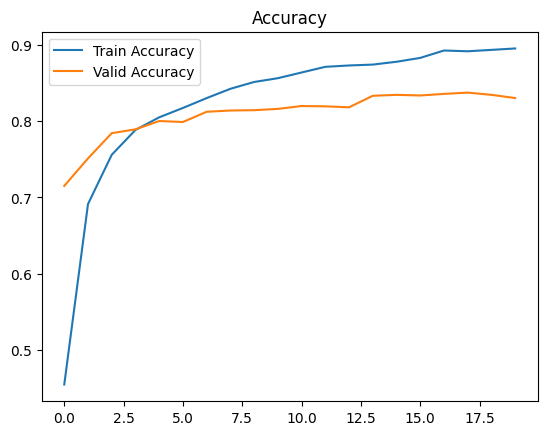

In [32]:
# 9. 모델 학습
# def fit(model, criterion, optimizer, epochs, train_loader, valid_loader)
fit(model, criterion, optimizer, epochs, train_loader, valid_loader)


#### 모델 저장
earlystoping 하면서 베스트 모델을 갱신하기 때문에 따로 모델을 저장하지 않아도 됨!

In [166]:
# import os
# import torch
# from datetime import datetime
# def saveModel():
#     # base 디렉토리 설정
#     base_dir = os.getcwd()  # 현재 작업 디렉토리

#     # base 디렉토리 아래에 'model' 폴더 경로 설정
#     modelPath = os.path.join(base_dir, 'model_food')

#     # 폴더가 존재하지 않으면 생성
#     if not os.path.exists(modelPath):
#         os.makedirs(modelPath)

#     # 모델 파일 이름 설정
#     # selected_model_name에 .pth 확장자를 추가
#     selected_model_name = f"{selected_model_name}.pth"

#     # 모델 저장
#     # 모델의 구조자체가 아닌 가중치와 편향등의 파라미터를 저장한다.(저장할 내용, 저장되는 경로)
#     torch.save(model.state_dict(), os.path.join(modelPath, selected_model_name))

#     print(f"{os.path.join(modelPath, selected_model_name)}으로 저장완료!")
    
# saveModel()

Model saved to c:\Users\SBA\repository\yolo\model_food\RESNET50.pth


100%|██████████| 75/75 [00:23<00:00,  3.24it/s]


test_correct: 2031, test_total: 2397
Test Loss: 0.4896, Test Accuracy: 84.73%


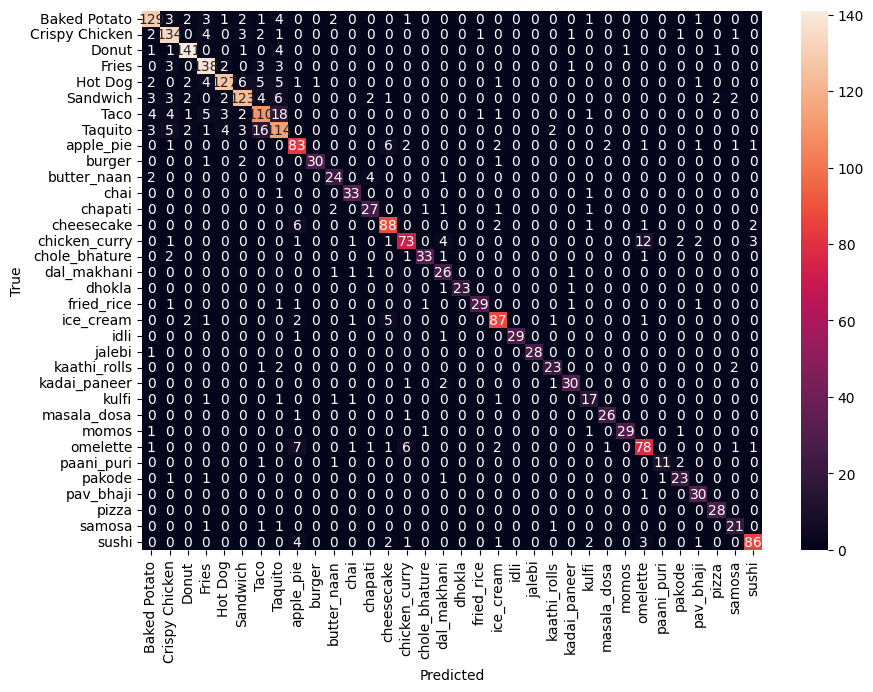

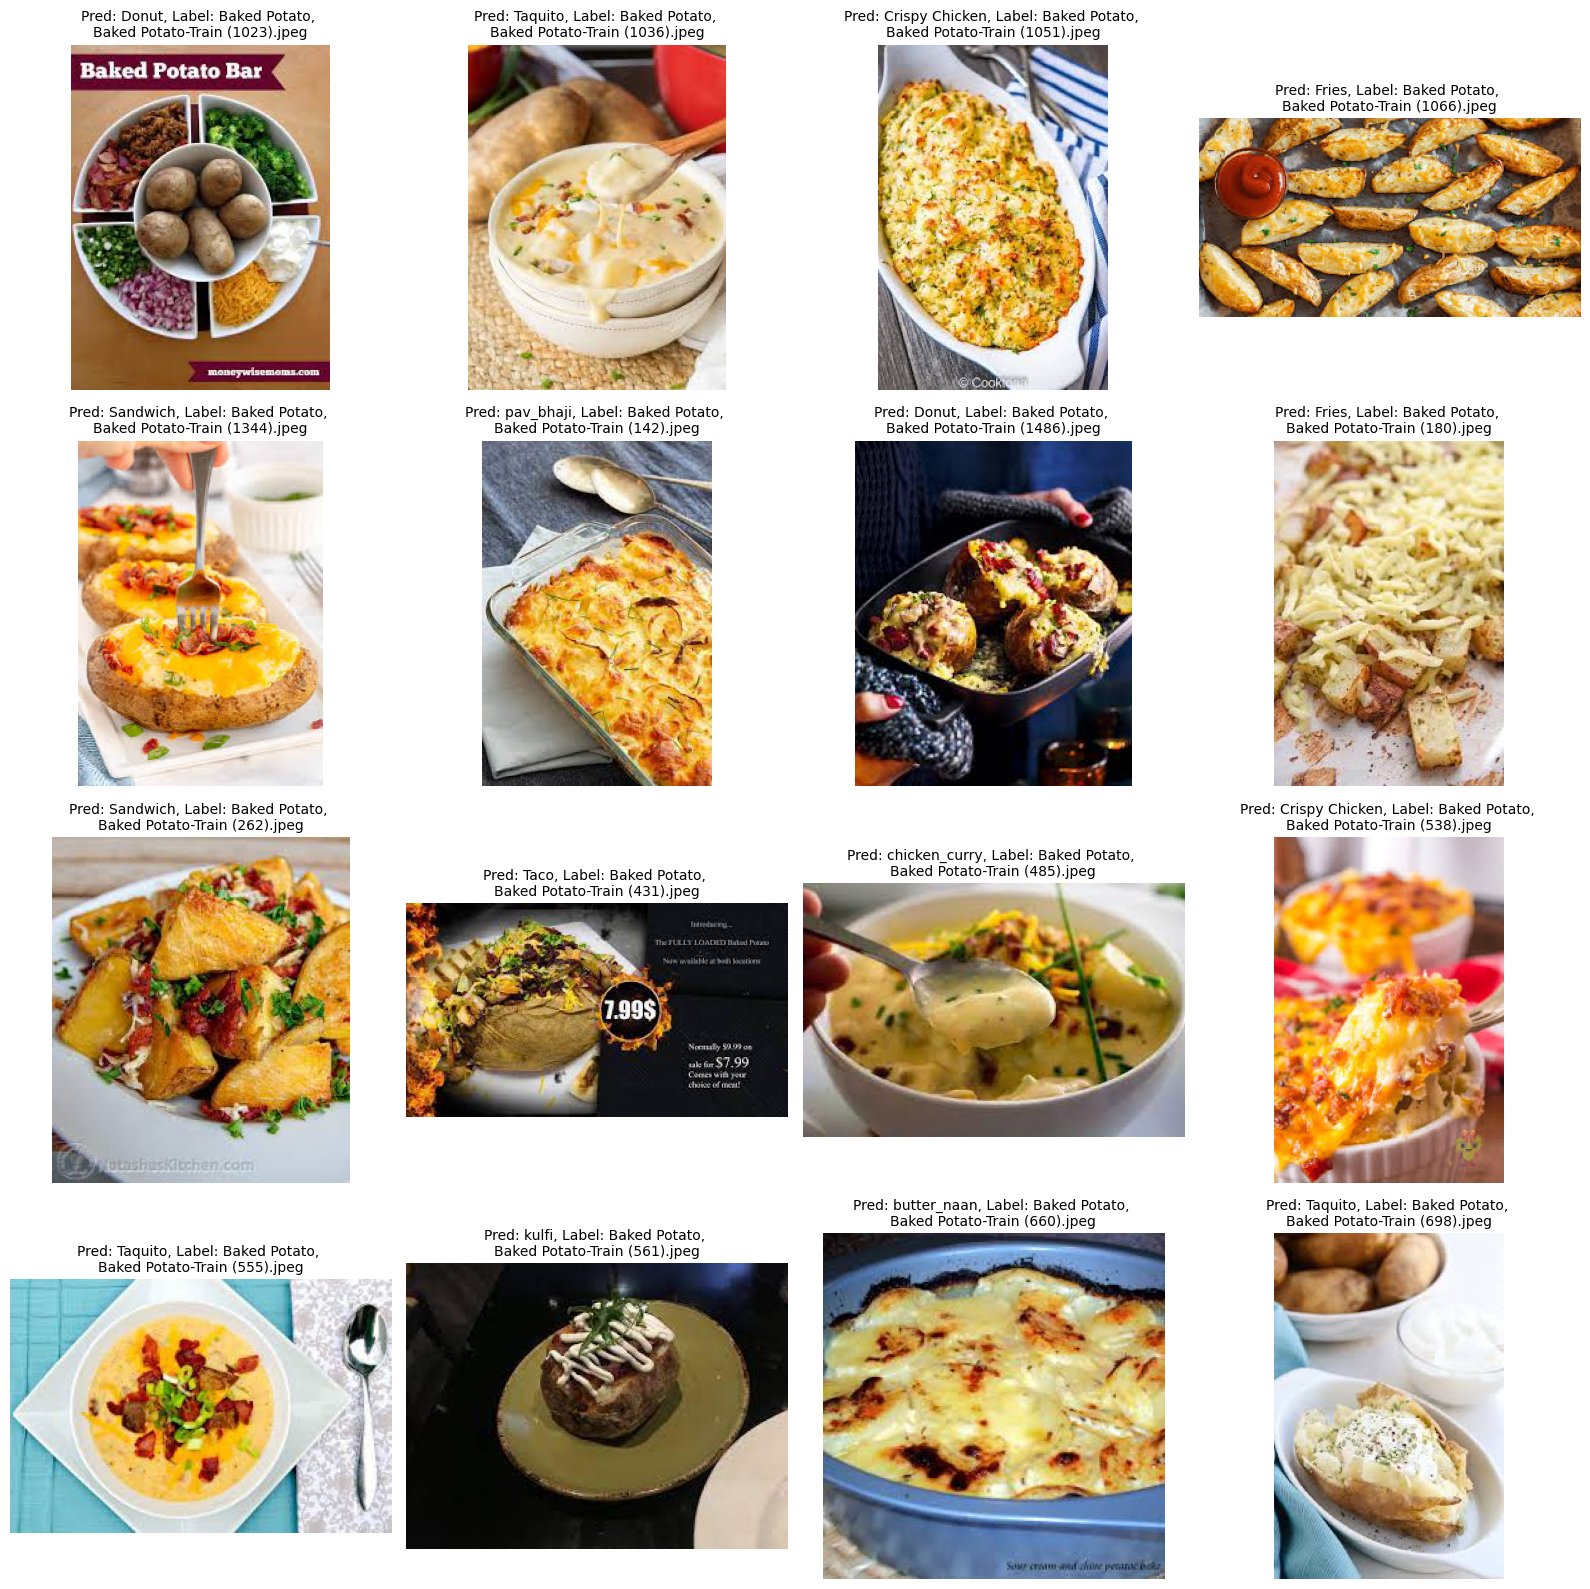

In [34]:
# 테스트 데이터를 통해 성능 평가 및 잘못된 예측 시각화
# 테스트 데이터에 레이블이 있는 경우
evaluate_and_visualize(model, test_loader, criterion)

In [ ]:
def load_best_model():
    # 가중치 로드
    state_dict = torch.load('model_food/RESNET50_best.pth', map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)

    # 평가 모드로 설정
    model.eval()

In [ ]:
import cv2

def webcam_classification():
    # 웹캠 열기
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret: # 제대로 읽어왔니
            break

        # OpenCV 이미지를 PIL 이미지로 변환
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # 이미지 전처리
        img_tensor = test_transform(img).unsqueeze(0)  # 배치 차원 추가
        # 원래 이미지 텐서의 크기가 (C, H, W) (채널, 높이, 너비)라면, unsqueeze(0)을 적용하면 (1, C, H, W)로 변환됩니다.

        # 예측
        with torch.no_grad():
            output = model(img_tensor)
            _, predicted = torch.max(output, 1)
            label = predicted.item()
            class_name = class_to_idx[label]  # 클래스명으로 변환
            

        # 예측한 레이블을 화면에 표시
        cv2.putText(frame, f"Predicted Label: {label}, {class_name}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # 웹캠 화면 출력
        cv2.imshow("Webcam", frame)

        # 'q'를 누르면 종료
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
if __name__ == "__main__":
    load_best_model()
    webcam_classification()

<span style="color:orange ; font-weight:bold; font-size:20px;">
    LesNet50 + epochs = 20/ optimizer = adam
    <br>
    분류기 첫 레이어 출력크기 : 1024
    <br> 
    dropout : 0.4 
    <br>
    learning rate : 0.0001 weight_decay : 0.005
</span>


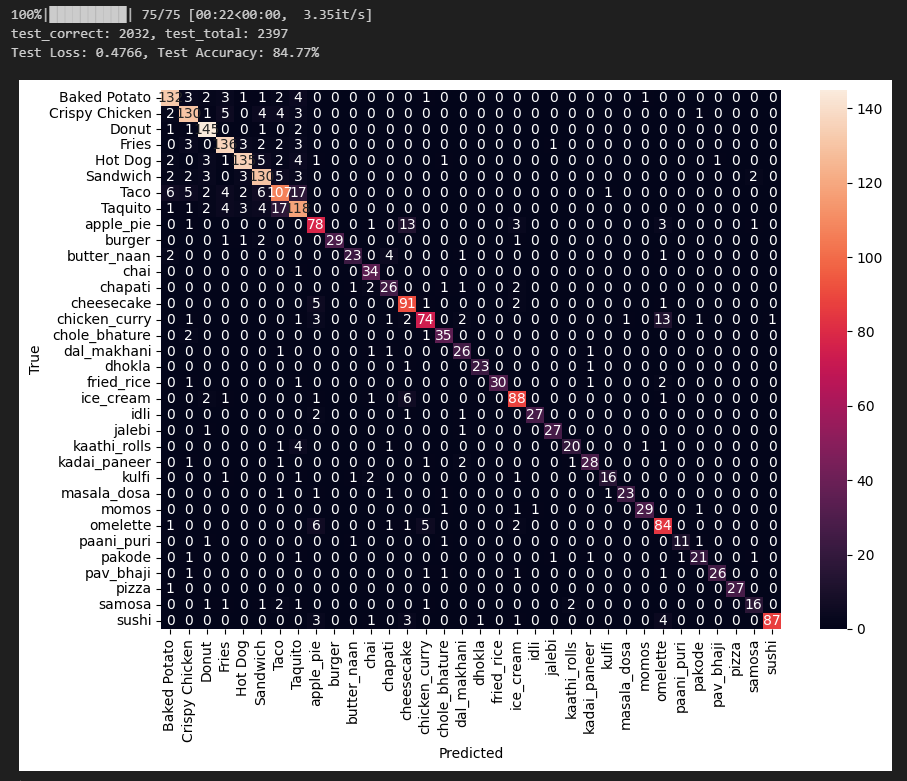

<span style="color:orange ; font-weight:bold; font-size:20px;">
    LesNet50 + epochs = 20/ optimizer = adam
    <br>
    분류기 첫 레이어 출력크기 : 512
    <br> 
    dropout : 0.3
    <br>
    learning rate : 0.0001 weight_decay : 0.005
</span>


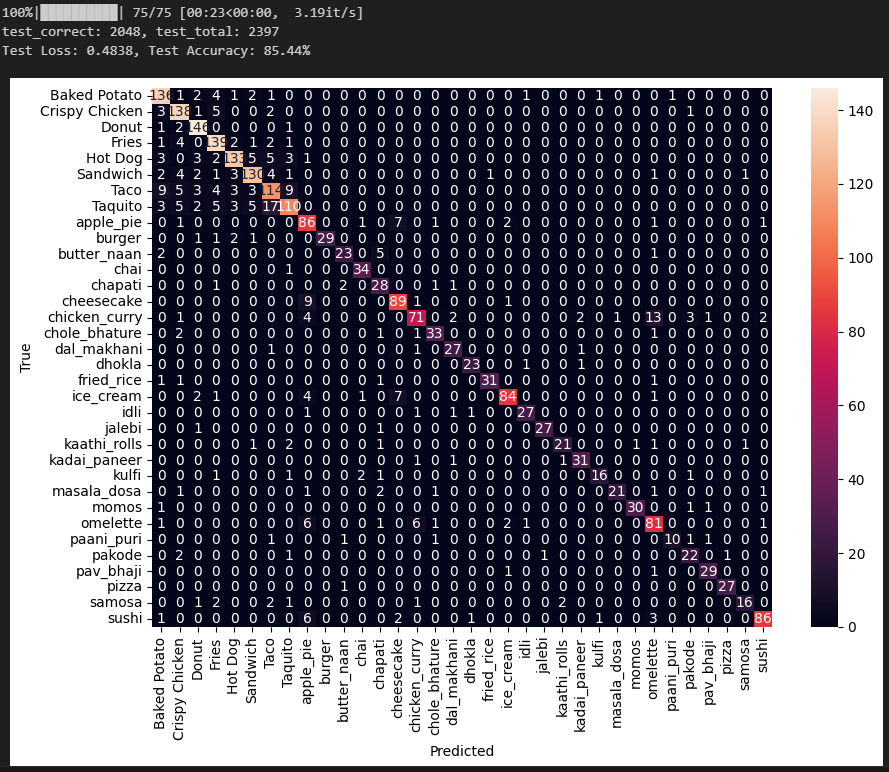